# Proyecto 1

## 1. Escoger la base de datos

Para el proyecto de análsisi de series de tiempo hemos escogido como base de datos los **Giros Pagados (monto en USD)** por las diferentes entidades financieras en Colombia entre el 31 de marzo de 2007 hasta el 31 de marzo de 2020. 

### Librerias

In [1]:
# Sistema
import os
import sys
import gc

# Manipulación de los datos
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import feather

# Visualización 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Manjeo del tiempo
import datetime
import time

# Análisis series de tiempo
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# Estadísticas
from sklearn.metrics import mean_squared_error
from scipy import stats

# Warnings
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
giros = pd.read_excel("../Datos/Proyecto 1_Giros Pagados.xlsx")
giros.head()

,Formato,Tipo_Entidad,Codigo_Entidad,NombreTipoEntidad,NombreEntidad,FechaCorte,Departamento,Municipio,Producto1,Valor
0,390,1,1,BC-ESTABLECIMIENTO BANCARIO,Banco De Bogota,2007-03-31,SANTANDER,BUCARAMANGA,GIROS PAGADOS MONTO EN USD,7625953.57
1,390,1,1,BC-ESTABLECIMIENTO BANCARIO,Banco De Bogota,2007-03-31,VALLE DEL CAUCA,GUACARI,GIROS PAGADOS MONTO EN USD,12431.00
2,390,1,1,BC-ESTABLECIMIENTO BANCARIO,Banco De Bogota,2007-03-31,META,ACACIAS,GIROS PAGADOS MONTO EN USD,10118.57
3,390,1,1,BC-ESTABLECIMIENTO BANCARIO,Banco De Bogota,2007-03-31,CUNDINAMARCA,MOSQUERA,GIROS PAGADOS MONTO EN USD,230964.73
4,390,1,1,BC-ESTABLECIMIENTO BANCARIO,Banco De Bogota,2007-03-31,ANTIOQUIA,YARUMAL,GIROS PAGADOS MONTO EN USD,35451.08


In [3]:
giros['FechaCorte'] = pd.to_datetime(giros['FechaCorte'])
giros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76569 entries, 0 to 76568
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Formato            76569 non-null  int64         
 1   Tipo_Entidad       76569 non-null  int64         
 2   Codigo_Entidad     76569 non-null  int64         
 3   NombreTipoEntidad  76569 non-null  object        
 4   NombreEntidad      76569 non-null  object        
 5   FechaCorte         76569 non-null  datetime64[ns]
 6   Departamento       76569 non-null  object        
 7   Municipio          76569 non-null  object        
 8   Producto1          76569 non-null  object        
 9   Valor              76569 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 5.8+ MB


In [4]:
serie = pd.DataFrame(giros.groupby(["NombreTipoEntidad", "FechaCorte"])["Valor"].count()) # Agrupamos por el número de giros
serie.reset_index(inplace = True)
serie.columns = ['Tipo_Entidad', 'Fecha', 'N_Operaciones']

In [5]:
serie = serie.pivot(index = 'Fecha', columns = 'Tipo_Entidad', values = 'N_Operaciones')
serie.columns = ['Bancario', 'CompFinanciamiento', 'CorpFinanciera', 'BolsaValores', 'Intermediación']
serie.head()

,Bancario,CompFinanciamiento,CorpFinanciera,BolsaValores,Intermediación
Fecha,,,,,
2007-03-31,710.0,122.0,8.0,46.0,71.0
2007-06-30,700.0,121.0,8.0,45.0,59.0
2007-09-30,770.0,129.0,8.0,47.0,42.0
2007-12-31,817.0,128.0,NaN,45.0,42.0
2008-03-31,1033.0,132.0,4.0,48.0,42.0


In [6]:
serie.fillna(0, inplace = True)
serie.head()

,Bancario,CompFinanciamiento,CorpFinanciera,BolsaValores,Intermediación
Fecha,,,,,
2007-03-31,710.0,122.0,8.0,46.0,71.0
2007-06-30,700.0,121.0,8.0,45.0,59.0
2007-09-30,770.0,129.0,8.0,47.0,42.0
2007-12-31,817.0,128.0,0.0,45.0,42.0
2008-03-31,1033.0,132.0,4.0,48.0,42.0


In [7]:
serie.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2007-03-31 to 2020-03-31
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bancario            53 non-null     float64
 1   CompFinanciamiento  53 non-null     float64
 2   CorpFinanciera      53 non-null     float64
 3   BolsaValores        53 non-null     float64
 4   Intermediación      53 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB


## 2. Contexto de la base

La base de datos que vamos a analizar contiene los giros pagados (en dólares) que las diferentes entidades financieras han realizado de manera trimestral desde marzo de 2007 a marzo de 2020. Dentro de la base se encuentra infomración relacionada con el tipo de entidad financiera, el nombre de la entidad, la fecha de giro, el departamento, municipio y el valor del giro. 

En este caso en particular nos queremos centrar en entender las dinamicas propias que ocurren no con el valor de los giros, sino con la cantidad de estos que hacen durante el tiempo los diferentes tipos de entidades financieras, las cuales son: Entidades Bancarias, Compañias de Financiamiento, Corporaciones Financieras, Bolsas de Valores e Intermediadoras.

Entender la cantidad de giros que hacen las entidades es de gran utilidad para el Estado, ya que permite tener un mayor control y entendimiento sobre el funcionamiento del mercado cambiario.

Es importante anotar que tras el proceso de limpieza y organización de la base de datos terminamos con cinco series de tiempo con un total de 53 observaciones temporales. Esto implica un reto en el proceso de ajuste, ya que al haber poca información sobre el pasado los resultados del modelo pueden tener sesgo.

## 3. Análisis de la información

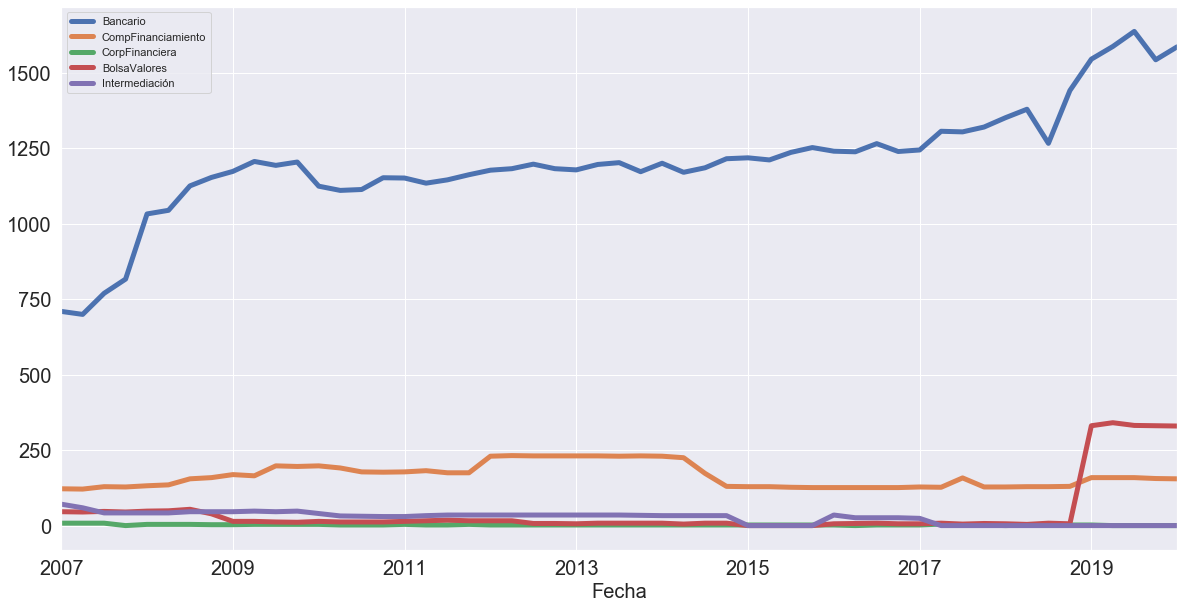

In [8]:
serie.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Fecha', fontsize=20);

Con base en la serie de tiempo de las cinco series de tiempo se observa que la entidad financiera con el mayor número de giros realizados es el Bancario, lo cual puede estar explicado bajo el hecho que los grandes proyectos de inversión en el país son financiados por entidades bancarias que requieren hacer giros en moneda extranjera. 

Es interesante observar, de igual forma, el cambio en el número de giros realizados por las entidades catalogadas como Bolsa de Valores, el cual tiene un salto significativo a finales del 2019. 

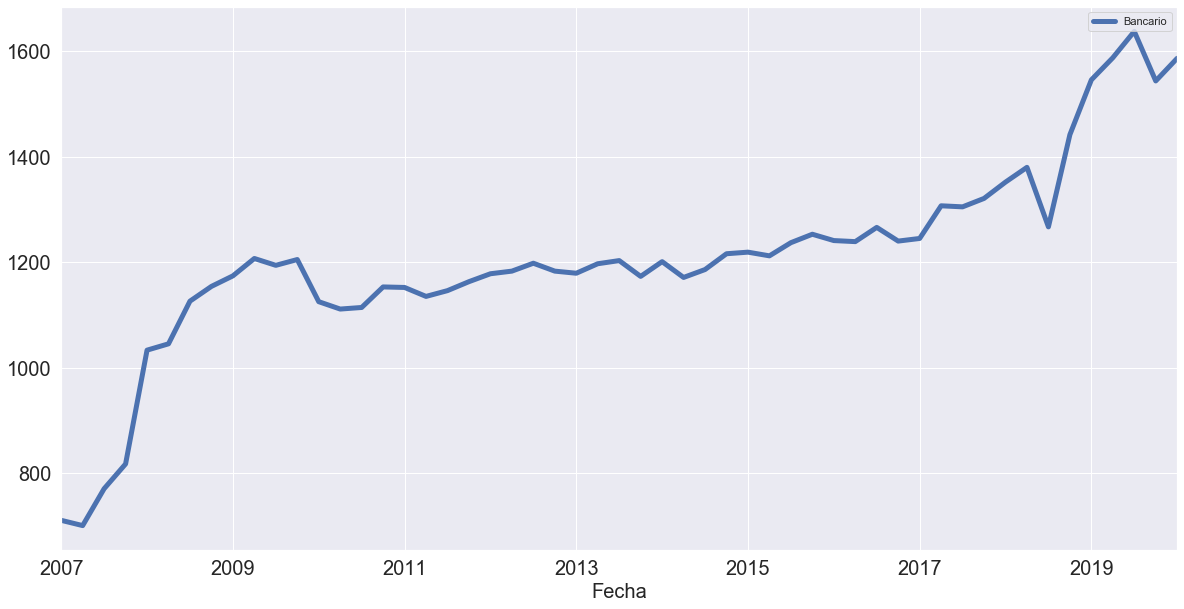

In [9]:
serie[['Bancario']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Fecha', fontsize=20);

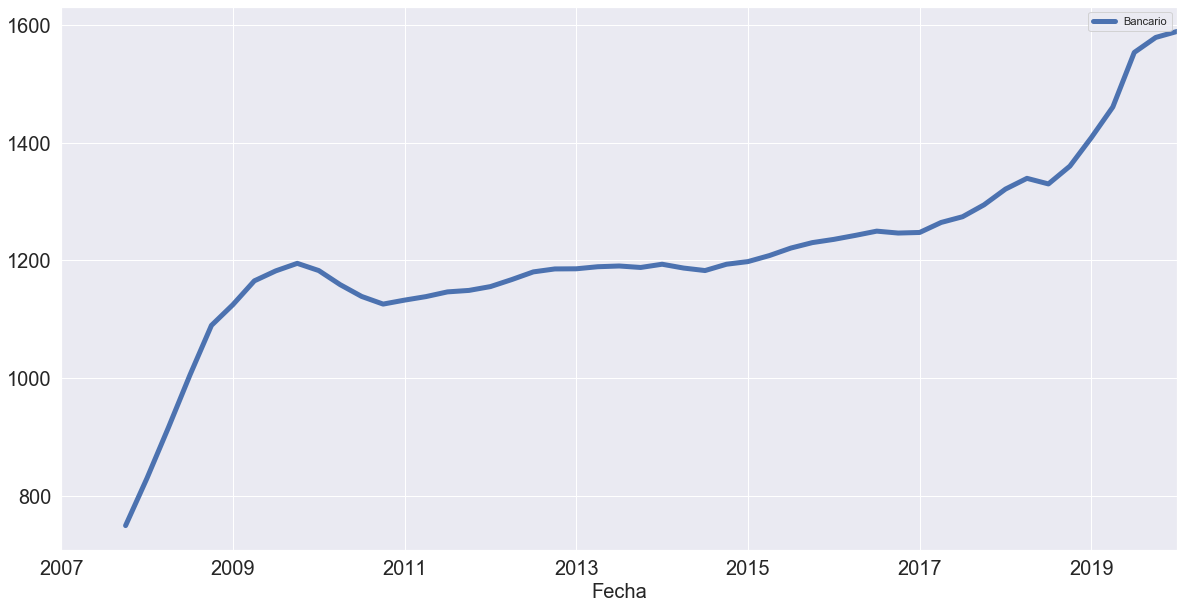

In [10]:
bancos = serie[['Bancario']]
bancos.rolling(4).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Fecha', fontsize=20);

Dado que la información es trimestral, graficamos el promedio movil de los últimos cuatro periodos. Hacemos este ejercicio para el caso del número de giros de las entidades bancarias, lo que da como resultado una seriesuavizada. Este resultado puede indicarnos que existe una estacionalidad trimestral, así como que existe una tendencia creciente. 

Al mirar el resto de series se observa, inicialmente, que no tienen una tendencia ni patron estacional. 

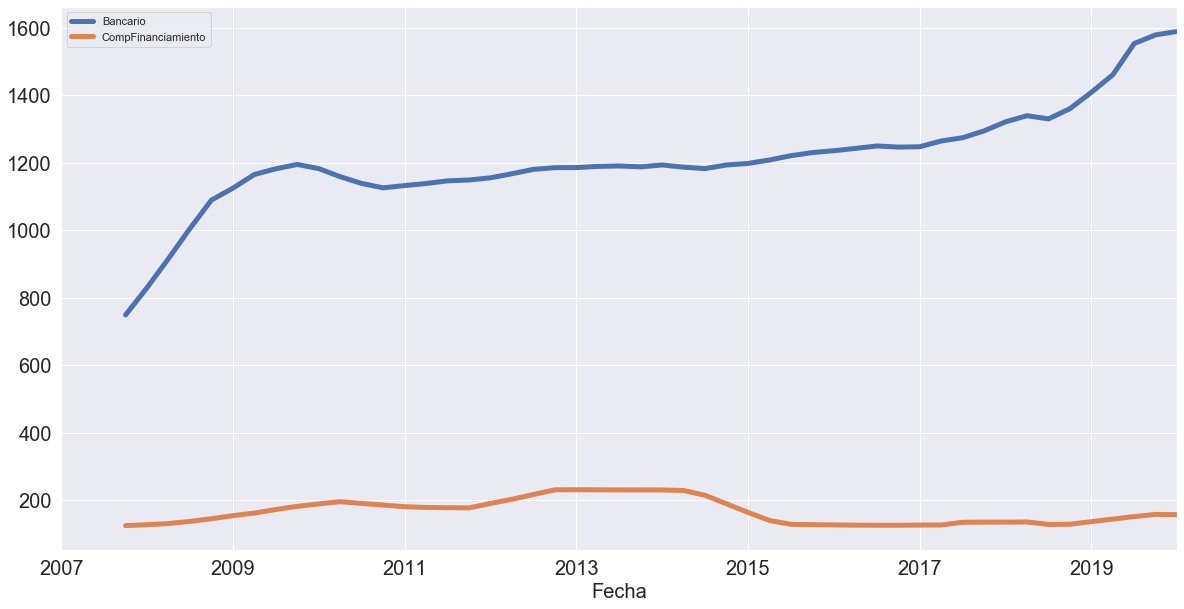

In [11]:
serie[['Bancario', 'CompFinanciamiento']].rolling(4).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Fecha', fontsize=20);

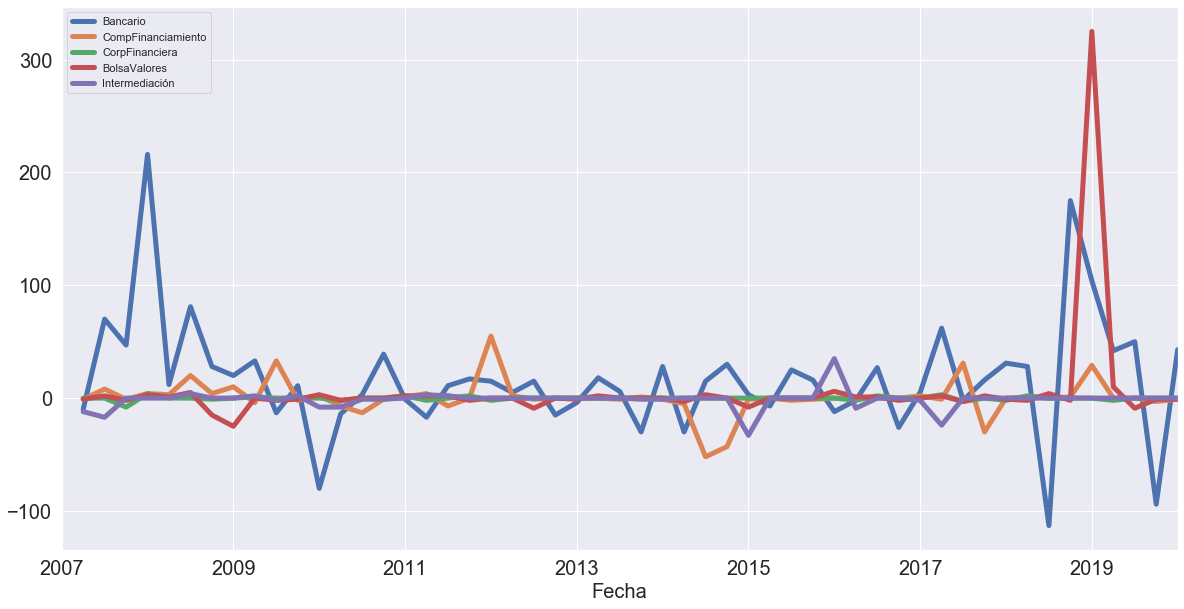

In [12]:
serie.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Fecha', fontsize=20);

In [13]:
col = serie.columns

for i in range(0, len(col)):
    print('\nTipo de Entidad:', col[i])    

    result = adfuller(serie[col[i]])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


Tipo de Entidad: Bancario
ADF Statistic: 2.645462
p-value: 0.999082
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603

Tipo de Entidad: CompFinanciamiento
ADF Statistic: -1.644009
p-value: 0.460167
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597

Tipo de Entidad: CorpFinanciera
ADF Statistic: -4.565729
p-value: 0.000149
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597

Tipo de Entidad: BolsaValores
ADF Statistic: -0.397686
p-value: 0.910484
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597

Tipo de Entidad: Intermediación
ADF Statistic: -2.243898
p-value: 0.190700
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597


Con el fin de mirar si las series son estacionarias o no hacemos la prueba de raíz unitaria de Dickey Fuller. Con base en esta prueba es posible concluir que 4 de las 5 series no son estacionarias. La serie relacionada con el número de giros de las Corporaciones Financieras presenta un comportamiento estacionario.

In [14]:
col = serie.columns

for i in range(0, len(col)):
    print('\nTipo de Entidad:', col[i])    

    result = adfuller(serie[col[i]].diff().iloc[1:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


Tipo de Entidad: Bancario
ADF Statistic: -7.145196
p-value: 0.000000
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598

Tipo de Entidad: CompFinanciamiento
ADF Statistic: -6.095547
p-value: 0.000000
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598

Tipo de Entidad: CorpFinanciera
ADF Statistic: -4.750295
p-value: 0.000068
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602

Tipo de Entidad: BolsaValores
ADF Statistic: -6.921644
p-value: 0.000000
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598

Tipo de Entidad: Intermediación
ADF Statistic: -5.133841
p-value: 0.000012
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Dado que 4 de las 5 series de tiempo no son estacionarias, a continuación, hacemos hacemos la misma prueba de Dicke Fuller, pero con las series diferenciadas. Esto lo hacemos con el fin de identificar si estás siguen un patron integrado de orden 1, lo cual, con base en la prueba, da como resultado que tras diferencias las series estás se vuelven estacionarias.

In [15]:
serie.corr()

,Bancario,CompFinanciamiento,CorpFinanciera,BolsaValores,Intermediación
Bancario,1.000000,0.014910,-0.699255,0.556655,-0.765300
CompFinanciamiento,0.014910,1.000000,-0.127076,-0.089363,0.322172
CorpFinanciera,-0.699255,-0.127076,1.000000,-0.295322,0.577042
BolsaValores,0.556655,-0.089363,-0.295322,1.000000,-0.358699
Intermediación,-0.765300,0.322172,0.577042,-0.358699,1.000000


In [16]:
serie.diff().corr()

,Bancario,CompFinanciamiento,CorpFinanciera,BolsaValores,Intermediación
Bancario,1.000000,0.085890,0.193643,0.233211,-0.034048
CompFinanciamiento,0.085890,1.000000,-0.133781,0.242547,0.004283
CorpFinanciera,0.193643,-0.133781,1.000000,0.020834,-0.076112
BolsaValores,0.233211,0.242547,0.020834,1.000000,0.042093
Intermediación,-0.034048,0.004283,-0.076112,0.042093,1.000000


Finalmnente, al mirar las correlaciones entre las diferentes series de tiempo diferenciadas es posible concluir que existe cierta relación positiva entre el número de giros de la entidades bancarias y el de las bolsas de valores. Es interesante observar que la correlación entre las entidades bancarias y las de intermediación es negativa, reflejando una posible competencia entre estas dos entidades. 

## 4. Modelo de predicción

In [17]:
def opt_arima(variable, p, d, q):
    
    """ Calcula el error cuadrático medio de un modelo ARIMA. 
    
    Args:
    -----
            variable: Variable de la base de datos
            p: Orden del AR
            d: Orden del I
            q: Orden del MA

    Returns:
    --------
            Raíz del error cuadratico medio

    """
    
    X = serie[variable].values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    yhat = list()
    
    for t in range(len(test)):
        model = ARIMA(history, order = (p,d,q))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    AR = p
    D = d
    MA = q
    error = mean_squared_error(test, predictions) ** 0.5
    print('p: %.0f, d: %.0f, q: %.0f, Test MSE: %.3f' % (AR, D, MA, error)) 

In [18]:
def roll_prophet(variable, porc):
    
    """ Calcula el error cuadrático medio utilizando Prophet. 
    
    Args:
    -----
            vairable: Variable de la base de datos
            porc: Establece el porcentaje de la base de prueba

    Returns:
    --------
            Raíz del error cuadratico medio

    """
   
    df = serie[[variable]]
    df.reset_index(inplace = True)
    df.columns = ['ds', 'y']
    
    X = df.copy()
    size = int(len(X) * porc)
    train, test = X[0:size], X[size:len(X)]
    predictions = list()

    for t in range(len(test)):
        m = Prophet(changepoint_prior_scale = 0.1)
        m.fit(train)

        future = m.make_future_dataframe(periods = 1 , freq = 'Q')
        forecast = m.predict(future)

        obs = forecast.iloc[-1]
        predictions.append(obs['yhat'])
        train.loc[size + t] = test.iloc[t]

    test['yhat'] = predictions
    
    error = mean_squared_error(test['y'], predictions) ** 0.5
    print('Test MSE: %.3f' % error)

### Entidad: Bancaria

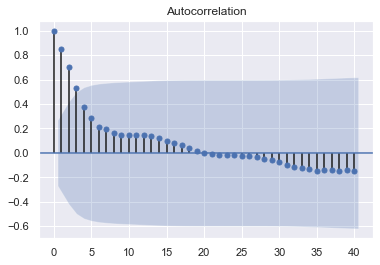

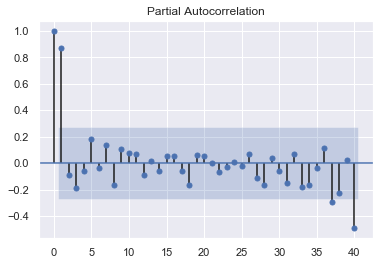

In [19]:
# Autocorrelación
plot_acf(serie['Bancario'], lags = 40);

# Autocorrelación Parcial
plot_pacf(serie['Bancario'], lags = 40);

De la observación visual tanto de la gráfica de la autocerrelación y como de la autocorrelación parcial es posible concluir que la el número de giros realizados por las entidades bancarias puede seguir un posible proceso ARIMA(1,1,0). Lo anterior se da porque la autocorrelación cae lentamente sobre el tiempo, mientras que la parcial presenta un pico importante en el rezago 1. De igual forma, teniendo en cuenta el resultado de la prueba de Dickey Fuller, es posible determinar que la serie no es estacionaria por lo que es integrada de orden 1.

In [20]:
for i in range(0, 6):
    for j in range(0, 6):
        try:
            opt_arima('Bancario', i, 1, j)
        except:
            pass

p: 0, d: 1, q: 0, Test MSE: 61.492
p: 0, d: 1, q: 1, Test MSE: 63.842
p: 0, d: 1, q: 2, Test MSE: 72.144
p: 0, d: 1, q: 3, Test MSE: 77.657
p: 0, d: 1, q: 4, Test MSE: 99.021
p: 0, d: 1, q: 5, Test MSE: 101.722
p: 1, d: 1, q: 0, Test MSE: 65.489
p: 2, d: 1, q: 0, Test MSE: 70.477
p: 2, d: 1, q: 1, Test MSE: 67.269
p: 3, d: 1, q: 0, Test MSE: 71.678
p: 3, d: 1, q: 1, Test MSE: 71.311
p: 4, d: 1, q: 0, Test MSE: 74.693
p: 4, d: 1, q: 1, Test MSE: 79.084
p: 4, d: 1, q: 2, Test MSE: 83.299
p: 4, d: 1, q: 3, Test MSE: 85.772
p: 5, d: 1, q: 0, Test MSE: 78.403
p: 5, d: 1, q: 1, Test MSE: 79.039


Utilizando la raíz del error cuadrático medio es posible concluir que el mejor modelo de pronóstico es un ARIMA(0,1,0); es decir, un modelo I(1) que indica que la serie tiene una constante que regula la tendencia o que tiene deriva. Dado este resultado, se modela la serie utilizando estos criterios.

In [21]:
roll_prophet('Bancario', 0.66);

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

Test MSE: 82.715


Ahora, al utilizar el método de Prophet se identifica que la predicción del modelo es inferior a la del modelo ARIMA(0,1,0). Esto se concluye con base en la raíz del error cuadrático medio que en este caso fue igual a 82.71, mientras que la del ARIMA(0,1,0) fue de 61.49. En este sentido, el pronóstico de la serie de tiempo se llevara a cabo utilizando este último modelo.

In [22]:
model = ARIMA(serie['Bancario'], order = (0,1,0), freq = 'Q')
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Bancario   No. Observations:                   52
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -279.040
Method:                           css   S.D. of innovations             51.791
Date:                Sat, 20 Jun 2020   AIC                            562.079
Time:                        19:56:31   BIC                            565.982
Sample:                    06-30-2007   HQIC                           563.576
                         - 03-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.8654      7.182      2.348      0.019       2.789      30.942


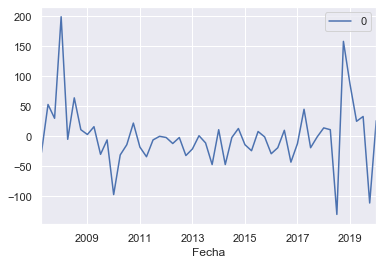

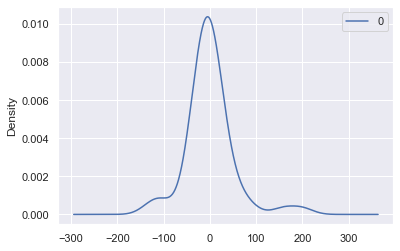

                  0
count  5.200000e+01
mean   5.465713e-16
std    5.229593e+01
min   -1.298654e+02
25%   -2.161538e+01
50%   -1.865385e+00
75%    1.338462e+01
max    1.991346e+02

Prueba de Shapiro-Wilk:
	Estadístico: 0.858743, p-value: 0.000
	Rechaza


In [23]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

print('\nPrueba de Shapiro-Wilk:')
print('\tEstadístico: %f, p-value: %.3f' % (stats.shapiro(residuals)[0], stats.shapiro(residuals)[1]))
if stats.shapiro(residuals)[1] > 0.05:
    print('\tNo Rechaza')
else:
    print('\tRechaza')

Tras ajustar la serie de tiempo utilizando un modelo ARIMA(0,1,0) se miran los residuos con el fin de validar si este es estacionario y, de igual forma, si sigue una distribución normal. En este caso, al mirar la gráfica de los residuos es posible observar que este no es estacionario, lo que permite concluir que el modelo seleccionado puede no ser el más apropiado. De igual forma, al mirar si el residuo sigue una distribución normal se concluye que, con base en la prueba de Shapiro-Wilk, que no es normal. 

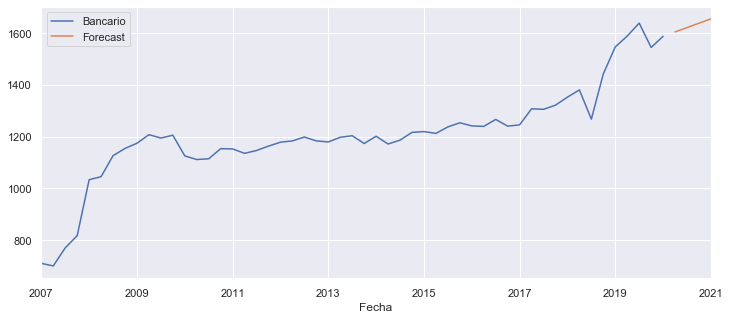

In [24]:
model = ARIMA(serie['Bancario'], order = (0,1,0), freq = 'Q')
model_fit = model.fit(disp = 0)

forecast = model_fit.predict(start = len(serie['Bancario']), 
                             end = (len(serie['Bancario'])-1) + 4,
                             typ = 'levels').rename('Forecast')
  
# Plot the forecast values 
serie['Bancario'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True);

In [25]:
df = serie[['Bancario']]
df.reset_index(inplace = True)
df.columns = ['ds', 'y']
    
m = Prophet(changepoint_prior_scale=0.08)
m.fit(df)

future = m.make_future_dataframe(periods = 4, freq = 'Q')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


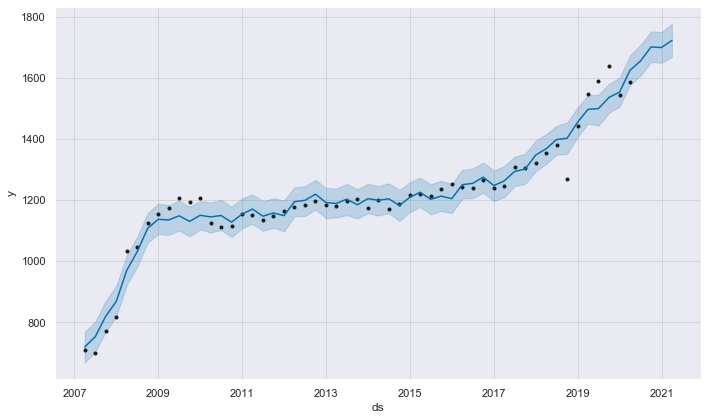

In [26]:
fig1 = m.plot(forecast)

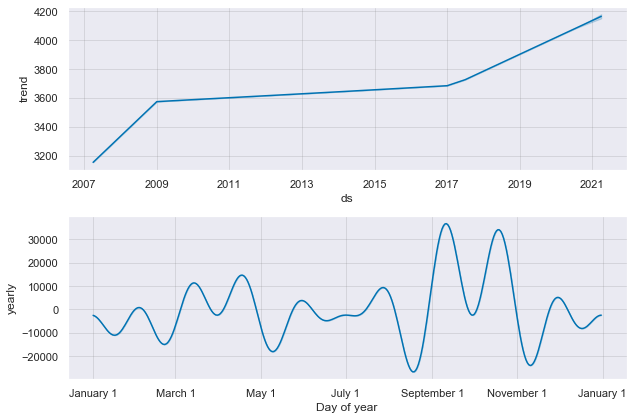

In [27]:
m.plot_components(forecast);

### Entidad: Compañias Financiamiento

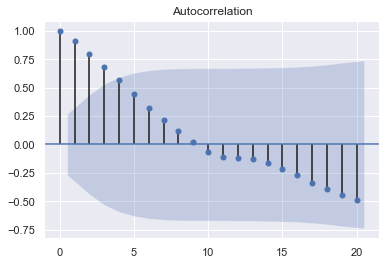

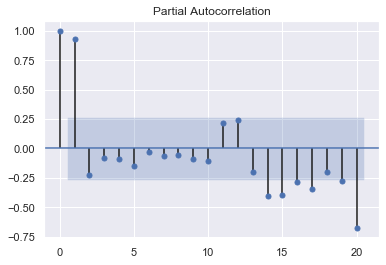

In [35]:
# Autocorrelación
plot_acf(serie['CompFinanciamiento'], lags = 20);

# Autocorrelación Parcial
plot_pacf(serie['CompFinanciamiento'], lags = 20);

In [36]:
for i in range(0, 6):
    for j in range(0, 6):
        try:
            opt_arima('CompFinanciamiento', i, 1, j)
        except:
            pass

p: 0, d: 1, q: 0, Test MSE: 12.069
p: 0, d: 1, q: 1, Test MSE: 13.319
p: 0, d: 1, q: 2, Test MSE: 13.392
p: 0, d: 1, q: 3, Test MSE: 13.420
p: 0, d: 1, q: 4, Test MSE: 13.401
p: 0, d: 1, q: 5, Test MSE: 13.565
p: 1, d: 1, q: 0, Test MSE: 13.361
p: 1, d: 1, q: 1, Test MSE: 13.375
p: 1, d: 1, q: 2, Test MSE: 13.278
p: 1, d: 1, q: 3, Test MSE: 13.480
p: 1, d: 1, q: 4, Test MSE: 13.720
p: 2, d: 1, q: 0, Test MSE: 13.375
p: 2, d: 1, q: 1, Test MSE: 13.364
p: 2, d: 1, q: 3, Test MSE: 13.281
p: 3, d: 1, q: 0, Test MSE: 13.383
p: 3, d: 1, q: 1, Test MSE: 13.582
p: 4, d: 1, q: 0, Test MSE: 13.447
p: 4, d: 1, q: 1, Test MSE: 13.341
p: 4, d: 1, q: 2, Test MSE: 14.852
p: 5, d: 1, q: 0, Test MSE: 13.446
p: 5, d: 1, q: 1, Test MSE: 13.815


In [37]:
roll_prophet('CompFinanciamiento', 0.66);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Test MSE: 38.092


                              ARIMA Model Results                               
Dep. Variable:     D.CompFinanciamiento   No. Observations:                   52
Model:                   ARIMA(0, 1, 0)   Log Likelihood                -215.946
Method:                             css   S.D. of innovations             15.392
Date:                  Sat, 20 Jun 2020   AIC                            435.892
Time:                          20:06:50   BIC                            439.795
Sample:                      06-30-2007   HQIC                           437.388
                           - 03-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6346      2.135      0.297      0.766      -3.549       4.818


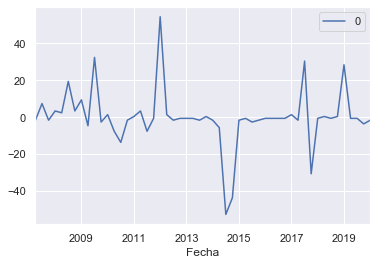

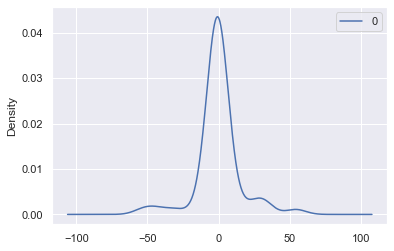

                  0
count  5.200000e+01
mean  -6.789441e-16
std    1.554251e+01
min   -5.263462e+01
25%   -1.634615e+00
50%   -6.346154e-01
75%    1.365385e+00
max    5.436538e+01

Prueba de Shapiro-Wilk:
	Estadístico: 0.728897, p-value: 0.000
	Rechaza


In [38]:
model = ARIMA(serie['CompFinanciamiento'], order = (0,1,0), freq = 'Q')
model_fit = model.fit(disp = 0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

print('\nPrueba de Shapiro-Wilk:')
print('\tEstadístico: %f, p-value: %.3f' % (stats.shapiro(residuals)[0], stats.shapiro(residuals)[1]))
if stats.shapiro(residuals)[1] > 0.05:
    print('\tNo Rechaza')
else:
    print('\tRechaza')

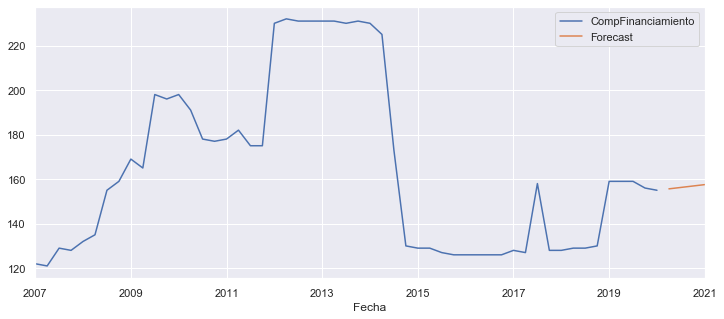

In [39]:
model = ARIMA(serie['CompFinanciamiento'], order = (0,1,0), freq = 'Q')
model_fit = model.fit(disp = 0)

forecast = model_fit.predict(start = len(serie['CompFinanciamiento']), 
                             end = (len(serie['CompFinanciamiento'])-1) + 4,
                             typ = 'levels').rename('Forecast')
  
# Plot the forecast values 
serie['CompFinanciamiento'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True);

In [40]:
df = serie[['CompFinanciamiento']]
df.reset_index(inplace = True)
df.columns = ['ds', 'y']
    
m = Prophet()
m.fit(df)

future = m.make_future_dataframe(periods = 4, freq = 'Q')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


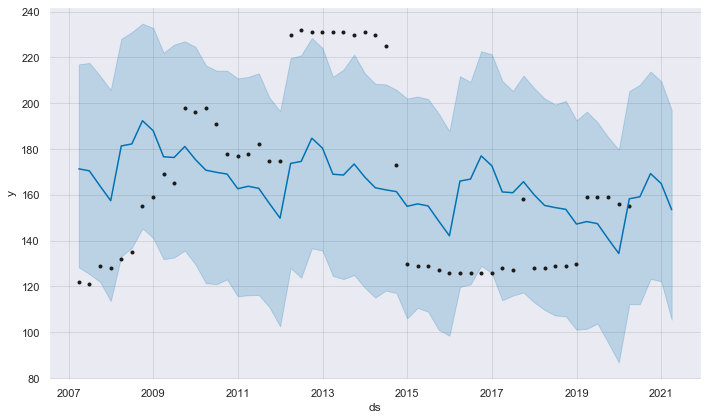

In [41]:
fig1 = m.plot(forecast)

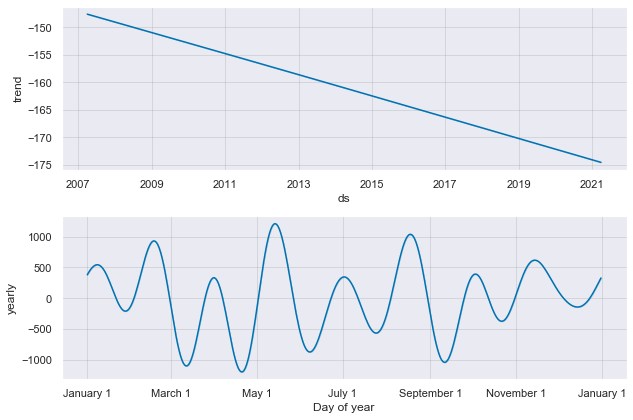

In [42]:
m.plot_components(forecast);

## 5. Conclusiones

Tras hacer el respectivo análisis de las series es posible concluir, por un lado, que el número de giros (en dólares) realizados por cuatro de las cinco entidades financieras no siguen un proceso estacionario, siendo la serie de las entidades bancarias un posible proceso con tendencia, mientras que las demás muestran ser relativamente constantes. 

De igual forma, al mirar el promedio movil de los últimos cuatro periodos se encuentra con que existe una posible estacionalidad trimestral. Ahora, al mirar el mejor proceso de ajuste para hacer un pronóstico se encuentra que la mejor opción para la serie 'Bancario' y 'CompFinanciamiento' es un ARIMA(0,1,0), que significa que ambas series son integradas de orden 1, la primera con deriva creciente. No obstate, luego de hacer de ajustar la serie bajo un proceso ARIMA(0,1,0) y mirar el comportamiento de los residuos se encuentra que estos no cumplen con el supuesto de normalidad, por lo que es posible que existe sesgo en el pronóstico de las series.